In [1]:
# general tools
import os
import re
import sys
import time
import h5py
import random
from glob import glob

import numpy as np
from datetime import datetime, timedelta
from random import shuffle

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [4]:
filepath_vec = "/glade/work/ksha/NCAR/"
filepath_valid = "/glade/campaign/cisl/aiml/ksha/NCAR_batch/"
filepath_test = "/glade/campaign/cisl/aiml/ksha/NCAR_batch_v4/"

In [5]:
data_lead2 = np.load('{}RESULT2_pp15_lead{}.npy'.format(filepath_vec, 2), allow_pickle=True)[()]
data_lead3 = np.load('{}RESULT_pp15_lead{}.npy'.format(filepath_vec, 3), allow_pickle=True)[()]
data_lead4 = np.load('{}RESULT_pp15_lead{}.npy'.format(filepath_vec, 4), allow_pickle=True)[()]

In [6]:
# data_lead2['test'] = 
#     data_lead2['valid'] = Y_pred_valid
#     data_lead2['label_test'] = TEST_Y
#     data_lead2['label_valid'] = VALID_Y

In [7]:
pred_test = np.concatenate((data_lead2['test'], data_lead3['test'], data_lead4['test']), axis=0)
true_test = np.concatenate((data_lead2['label_test'], data_lead3['label_test'], data_lead4['label_test']), axis=0)
pred_valid = np.concatenate((data_lead2['valid'], data_lead3['valid'], data_lead4['valid']), axis=0)
true_valid = np.concatenate((data_lead2['label_valid'], data_lead3['label_valid'], data_lead4['label_valid']), axis=0)

In [8]:
# pred_test = data_lead3['test']
# true_test = data_lead3['label_test']
# pred_valid = data_lead3['valid']
# true_valid = data_lead3['label_valid']

In [10]:
fig_dir

'/glade/u/home/ksha/figures/'

**Batch file info**

In [9]:
filename_valid_lead2 = sorted(glob("{}VALID*neg_neg_neg*lead{}.npy".format(filepath_valid, 2))) + \
                       sorted(glob("{}VALID*pos*lead{}.npy".format(filepath_valid, 2)))

filename_valid_lead3 = sorted(glob("{}VALID*neg_neg_neg*lead{}.npy".format(filepath_valid, 3))) + \
                       sorted(glob("{}VALID*pos*lead{}.npy".format(filepath_valid, 3)))

filename_valid_lead4 = sorted(glob("{}VALID*neg_neg_neg*lead{}.npy".format(filepath_valid, 4))) + \
                       sorted(glob("{}VALID*pos*lead{}.npy".format(filepath_valid, 4)))


KeyboardInterrupt



In [10]:
filename_valid = filename_valid_lead2 + filename_valid_lead3 + filename_valid_lead4

In [11]:
filename_test_lead2 = sorted(glob("{}*neg_neg_neg*lead{}.npy".format(filepath_test, 2))) + \
                      sorted(glob("{}*pos*lead{}.npy".format(filepath_test, 2)))

filename_test_lead3 = sorted(glob("{}*neg_neg_neg*lead{}.npy".format(filepath_test, 3))) + \
                      sorted(glob("{}*pos*lead{}.npy".format(filepath_test, 3)))

filename_test_lead4 = sorted(glob("{}*neg_neg_neg*lead{}.npy".format(filepath_test, 4))) + \
                      sorted(glob("{}*pos*lead{}.npy".format(filepath_test, 4)))

In [12]:
filename_test = filename_test_lead2 + filename_test_lead3 + filename_test_lead4

In [13]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    elev_3km = h5io['elev_3km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]
    
grid_shape = land_mask_80km.shape

elev_80km = du.interp2d_wraper(lon_3km, lat_3km, elev_3km, lon_80km, lat_80km, method='linear')
elev_80km[np.isnan(elev_80km)] = 0
elev_80km[elev_80km<0] = 0

In [14]:
def feature_extract(filenames, lon_80km, lat_80km, elev_80km):
    
    lon_out = []
    lat_out = []
    elev_out = []
    lead_out = []
    mon_out = []
    
    base_v3_s = datetime(2018, 7, 15)
    base_v3_e = datetime(2020, 12, 2)

    base_v4_s = datetime(2020, 12, 3)
    base_v4_e = datetime(2022, 7, 15)

    base_ref = datetime(2010, 1, 1)
    
    date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
    date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180-151)]
    
    for i, name in enumerate(filenames):
        
        if 'v4' in name:
            date_list = date_list_v4
        else:
            date_list = date_list_v3
        
        nums = re.findall(r'\d+', name)
        lead = int(nums[-1])
        indy = int(nums[-2])
        indx = int(nums[-3])
        day = int(nums[-4])
        day = date_list[day]
        month = day.month
        
        month_norm = (month - 1)/(12-1)
        
        lon = lon_80km[indx, indy]
        lat = lat_80km[indx, indy]
        elev = elev_80km[indx, indy]

                
        lon_out.append(lon)
        lat_out.append(lat)
        elev_out.append(elev)
        lead_out.append(lead)
        mon_out.append(month_norm)
        
    return np.array(lon_out), np.array(lat_out), np.array(elev_out), np.array(lead_out), np.array(mon_out)

In [15]:
lon_valid, lat_valid, elev_valid, lead_valid, mon_valid = feature_extract(filename_valid, lon_80km, lat_80km, elev_80km)
lon_test, lat_test, elev_test, lead_test, mon_test = feature_extract(filename_test, lon_80km, lat_80km, elev_80km)

In [16]:
# EAST = np.mean(lon_80km[:, 43])
# flag_valid_east = lon_valid >= EAST
# flag_valid_west = lon_valid < EAST
# flag_test_east = lon_test >= EAST
# flag_test_west = lon_test < EAST

**reliability diagram functions**

In [17]:
from sklearn.metrics import brier_score_loss

In [18]:
def reliability_diagram(cate_true, prob_model, bins):
    binids = np.searchsorted(bins, prob_model)
    bin_sums = np.bincount(binids, weights=prob_model, minlength=len(bins))
    bin_true = np.bincount(binids, weights=cate_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))
    flag = bin_total > 0
    prob_true = bin_true/bin_total
    prob_pred = bin_sums/bin_total
    prob_true[~flag] = np.nan
    return prob_true, prob_pred

def bs_3c(pred, frac, o, use):
    '''
    bs three components decompose
    '''
    rel = np.nansum(((pred - frac)**2)*use)/np.sum(use)
    res = np.nansum(((frac - o)**2)*use)/np.sum(use)
    return rel, res

def reliability_diagram_calc(y_true, y_pred_calib, N_boost=100, N_bins=25):
    L = len(y_pred_calib)
    hist_bins = np.linspace(0, 1, N_bins)

    prob_true = np.empty((N_bins, N_boost))
    prob_pred = np.empty((N_bins, N_boost))
    
    
    for n in range(N_boost):

        ind_bagging = np.random.choice(L, size=L, replace=True)
        obs_ = y_true[ind_bagging]
        fcst_ = y_pred_calib[ind_bagging]

        prob_true_, prob_pred_ = reliability_diagram(obs_, fcst_, hist_bins)
        prob_true[:, n] = prob_true_
        prob_pred[:, n] = prob_pred_
        
        
    o_bar = np.mean(y_true)
    hist_bins_ = np.mean(prob_pred, axis=1)
    hist_bins_[0] = 0

    use_, _ = np.histogram(y_pred_calib, bins=np.array(list(hist_bins_)+[1.0]))
    #use = use_/L
    
    prob_pred_mean = np.mean(prob_pred, axis=1)
    prob_true_mean = np.mean(prob_true, axis=1)

    prob_pred_mean[0] = 0
    prob_true_mean[0] = 0
    return prob_true, prob_pred, hist_bins_, use_, o_bar, prob_pred_mean, prob_true_mean


def bss_component_calc(y_true, y_pred_calib, prob_pred_mean, prob_true_mean, o_bar, use_):
    
    rel, res = bs_3c(prob_pred_mean, prob_true_mean, o_bar, use_)
    bs = brier_score_loss(y_true, y_pred_calib)
    res = (o_bar)*(1-o_bar) + rel - bs
    bss = (o_bar-bs)/(o_bar)
    
    return bss, bs, rel, res, o_bar

def performance_diagram_calc(y_true, y_pred_calib, N=50):
    thres = np.linspace(0.01, 0.35, N)
    pod = np.empty(N)
    sr = np.empty(N)

    for i, thre in enumerate(thres):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_calib>thre).ravel()
        pod[i] = tp / (tp + fn)

        if fp + tp > 1:
            sr[i] = tp / (fp + tp)
        else:
            sr[i] = np.nan
            
    return sr, pod
    

In [19]:
#from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

In [20]:
def verf_auc_bss(y_true, y_pred):
    fpr_v, tpr_v, _ = roc_curve(y_true, y_pred)
    o_bar_v = np.mean(y_true)

    bs_v = brier_score_loss(y_true, y_pred)
    auc_score_v = auc(fpr_v, tpr_v)
    bss_v = (o_bar_v-bs_v)/(o_bar_v)

    return auc_score_v, bss_v, bs_v

In [21]:
package_v = reliability_diagram_calc(true_valid, pred_valid[:, 0], N_boost=50, N_bins=30)
prob_true_v, prob_pred_v, hist_bins_v, use_v, o_bar_v, prob_pred_mean_v, prob_true_mean_v, = package_v

package_v = bss_component_calc(true_valid, pred_valid[:, 0], prob_pred_mean_v, prob_true_mean_v, o_bar_v, use_v)
bss_v, bs_v, rel_v, res_v, o_bar_v = package_v

Lv = len(true_valid)

/glade/scratch/ksha/ipykernel_283153/3118118045.py:7: RuntimeWarning: invalid value encountered in divide
  prob_true = bin_true/bin_total
/glade/scratch/ksha/ipykernel_283153/3118118045.py:8: RuntimeWarning: invalid value encountered in divide
  prob_pred = bin_sums/bin_total


In [22]:
package_t = reliability_diagram_calc(true_test, pred_test[:, 0], N_boost=50, N_bins=30)
prob_true_t, prob_pred_t, hist_bins_t, use_t, o_bar_t, prob_pred_mean_t, prob_true_mean_t, = package_t

package_t = bss_component_calc(true_test, pred_test[:, 0], prob_pred_mean_t, prob_true_mean_t, o_bar_t, use_t)
bss_t, bs_t, rel_t, res_t, o_bar_t = package_t

Lt = len(true_test)

/glade/scratch/ksha/ipykernel_283153/3118118045.py:7: RuntimeWarning: invalid value encountered in divide
  prob_true = bin_true/bin_total
/glade/scratch/ksha/ipykernel_283153/3118118045.py:8: RuntimeWarning: invalid value encountered in divide
  prob_pred = bin_sums/bin_total


In [23]:
auc_score_v, bss_v, bs_v = verf_auc_bss(true_valid, pred_valid[:, 0])

auc_score_t, bss_t, bs_t = verf_auc_bss(true_test, pred_test[:, 0])

In [24]:
sr_v, pod_v = performance_diagram_calc(true_valid, pred_valid[:, 0], N=50)
sr_t, pod_t = performance_diagram_calc(true_test, pred_test[:, 0], N=50)

In [25]:
csi_v = ((1 / sr_v) + (1 / pod_v) - 1) ** -1
max_v = np.max(csi_v)
thres_max_v = np.linspace(0.01, 0.35, 50)[np.argmax(csi_v)]

csi_t = ((1 / sr_t) + (1 / pod_t) - 1) ** -1
max_t = np.max(csi_t)
thres_max_t = np.linspace(0.01, 0.35, 50)[np.argmax(csi_t)]

In [26]:
print('========== Valid ==========')
print('auc: {}'.format(auc_score_v))
print('o_bar: {}'.format(o_bar_v))
print('bs: {}'.format(bs_v))
print('bss: {}'.format(bss_v))
print('========== Test ==========')
print('auc: {}'.format(auc_score_t))
print('o_bar: {}'.format(o_bar_t))
print('bs: {}'.format(bs_t))
print('bss: {}'.format(bss_t))

========== Valid ==========
auc: 0.9982985404881927
o_bar: 0.0012599250506123737
bs: 0.0010043350485726052
bss: 0.2028612748953135
========== Test ==========
auc: 0.9380939385691175
o_bar: 0.0008888186612415809
bs: 0.0008582442428323289
bss: 0.03439893843648935


## Figure

In [27]:
need_publish = True

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [28]:
fig_keys['dpi']

250

/glade/scratch/ksha/ipykernel_283153/4144005440.py:118: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(fig_dir+'relia_bss_perf_v3.png', format='png', **fig_keys)


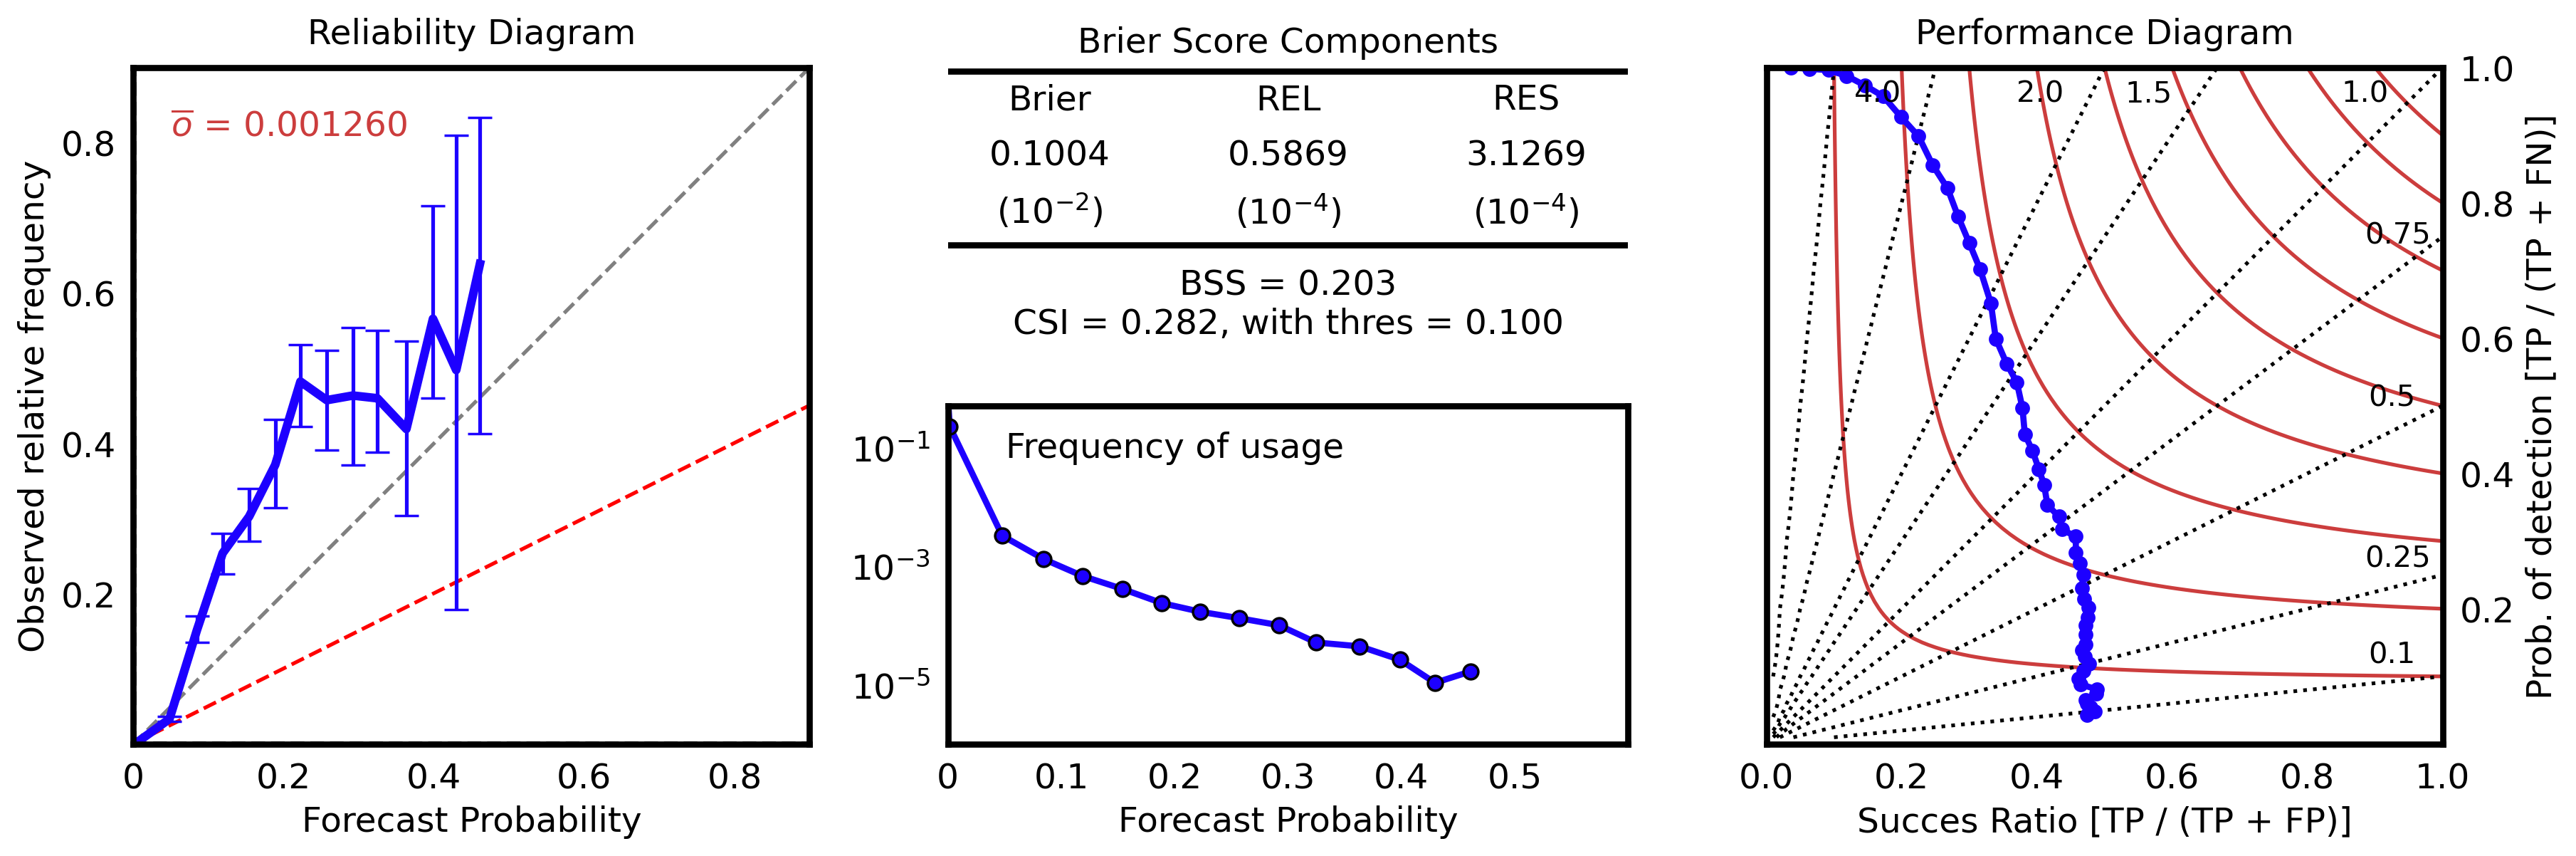

In [29]:
color_ = blue #cyan

fig = plt.figure(figsize=(13, 3.8), dpi=dpi_)
gs = gridspec.GridSpec(2, 3, height_ratios=[0.5, 0.5], width_ratios=[1/3, 1/3, 1/3])

ax_re = plt.subplot(gs[:, 0])
ax_csi = plt.subplot(gs[:, 2])
ax_table = plt.subplot(gs[0, 1])
ax_freq = plt.subplot(gs[1, 1])

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.2)

# ========== #
ax = ax_re
# ========== #
ax = gu.ax_decorate_box(ax)
# no skill line
fake_x = np.linspace(0, 1, 100)
fake_y = 0.5*fake_x + 0.5*o_bar_v
ax.plot(fake_x, fake_x, linewidth=1.5, linestyle='--', color='0.5')
ax.plot(fake_x, fake_y, linewidth=1.5, linestyle='--', color='r')
# axis ticks
ax.tick_params(axis="both", which="both", labelbottom=True, labelleft=True)
ax.set_xlim([0, 0.9])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8])
ax.set_ylim([0, 0.9])
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels([0.2, 0.4, 0.6, 0.8])
ax.set_aspect('equal')
# axis labels
ax.set_ylabel('Observed relative frequency', fontsize=14)
ax.set_xlabel('Forecast Probability', fontsize=14)
# climatology line
ax.text(0.05, 0.8, r'$\overline{o}$ = 0.001260', ha='left', va='bottom', color=red, fontsize=14)
ax.axvline(x=o_bar_v, ymin=0, ymax=1, linewidth=1.5, linestyle='--', color='0.5')
ax.axhline(y=o_bar_v, xmin=0, xmax=1, linewidth=1.5, linestyle='--', color='0.5')
ax.text(0.5, 1.025, 'Reliability Diagram', ha='center', va='bottom', color='k', fontsize=14, transform=ax.transAxes)

temp_95_v = np.quantile(prob_true_v, 0.95, axis=1) - prob_true_mean_v
temp_05_v = prob_true_mean_v - np.quantile(prob_true_v, 0.05, axis=1)
error_v = np.array(list(zip(temp_05_v, temp_95_v))).T
ax.errorbar(prob_pred_mean_v, prob_true_mean_v, yerr=error_v, linestyle='-', capsize=5, color=color_, linewidth=3.5, elinewidth=1.5)

# ========== #
ax = ax_table
# ========== #
ax.set_axis_off()
table_heads = ['Brier', 'REL', 'RES']
locx_heads = [0.15, 0.50, 0.85]
scales = [r'($10^{-2}$)', r'($10^{-4}$)', r'($10^{-4}$)']
ax.text(0.5, 1.025, 'Brier Score Components', ha='center', va='bottom', color='k', fontsize=14, transform=ax.transAxes)
pad = 0.075

for j in range(3):
    ax.text(locx_heads[j], 0.93-pad, table_heads[j], ha='center', va='bottom', 
                  fontsize=14, transform=ax.transAxes)
    ax.text(locx_heads[j], 0.65-pad, scales[j], ha='center', va='center', 
              fontsize=14, transform=ax.transAxes)
ax.text(locx_heads[0], 0.765-pad, '{:.4f}'.format(bs_v*1e2), ha='center', va='bottom', 
              color='k', fontsize=14, transform=ax.transAxes)
ax.text(locx_heads[1], 0.765-pad, '{:.4f}'.format(rel_v*1e4), ha='center', va='bottom', 
              color='k', fontsize=14, transform=ax.transAxes)
ax.text(locx_heads[2], 0.765-pad, '{:.4f}'.format(res_v*1e4), ha='center', va='bottom', 
              color='k', fontsize=14, transform=ax.transAxes)
ax.axhline(y=0.99, xmin=0, xmax=1.25, linewidth=2.5, linestyle='-', color='k')
ax.axhline(y=0.55-pad, xmin=0, xmax=1.25, linewidth=2.5, linestyle='-', color='k')
ax.text(0.5, 0.375-pad, 'BSS = {:.3f}\nCSI = {:.3f}, with thres = {:.3f}'.format(bss_v, max_v, thres_max_v), ha='center', va='center', 
              fontsize=14, transform=ax.transAxes)

# ========== #
ax = ax_freq
# ========== #
ax = gu.ax_decorate_box(ax)
ax.tick_params(axis="both", which="both", labelbottom=True, labelleft=True)
ax.set_xlim([0, 0.6])
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yscale('log')
ax.set_ylim([1e-6, 0.5])
ax.set_yticks([1e-5, 1e-3, 1e-1])
ax.text(0.2, 0.1, 'Frequency of usage', ha='center', va='center', fontsize=14)
ax.set_xlabel('Forecast Probability', fontsize=14)

ax.plot(hist_bins_v, use_v/Lv, '-o', color=color_, linewidth=2.5, ms=6, mec='k', mfc=color_)

# ========== #
ax = ax_csi
# ========== #
ax = gu.ax_decorate_box(ax)
ax.tick_params(axis="both", which="both", labelbottom=True, labelright=True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_aspect('equal')
x_axis = np.arange(0.01, 1.01, 0.01)
y_axis = np.arange(0.01, 1.01, 0.01)
x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)
csi = ((1 / x_mesh) + (1 / y_mesh) - 1) ** -1
cs_ = ax.contour(x_mesh, y_mesh, csi, np.arange(0.0, 1.1, 0.1), colors=(red,), linestyles='-')
biases = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0, 10.0]
bias_loc_x = [0.94, 0.935, 0.94, 0.935, 0.9, 0.58, 0.42, 0.18, 0.03]
bias_loc_y = [0.12, 0.2625, 0.5, 0.74, 0.95, 0.95, 0.95, 0.95, 0.95]
bias = y_mesh / x_mesh
ax.contour(x_mesh, y_mesh, bias, biases, colors='k', linestyles=':')
for i, label in enumerate(biases):
    ax.annotate(label, (bias_loc_x[i]-0.05, bias_loc_y[i]), fontsize=12)

ax.text(0.5, 1.025, 'Performance Diagram', ha='center', va='bottom', color='k', fontsize=14, transform=ax.transAxes)
ax.set_xlabel('Succes Ratio [TP / (TP + FP)]', fontsize=14)
ax.yaxis.set_label_position("right")

ax.set_ylabel('Prob. of detection [TP / (TP + FN)]', fontsize=14)

ax.plot(sr_v, pod_v, 'o-', color=color_, linewidth=2.5, ms=6, mew=0.0, mfc=color_)

fig.savefig(fig_dir+'relia_bss_perf_v3.png', format='png', **fig_keys)

/glade/scratch/ksha/ipykernel_283153/577582877.py:118: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(fig_dir+'relia_bss_perf_v4.png', format='png', **fig_keys)


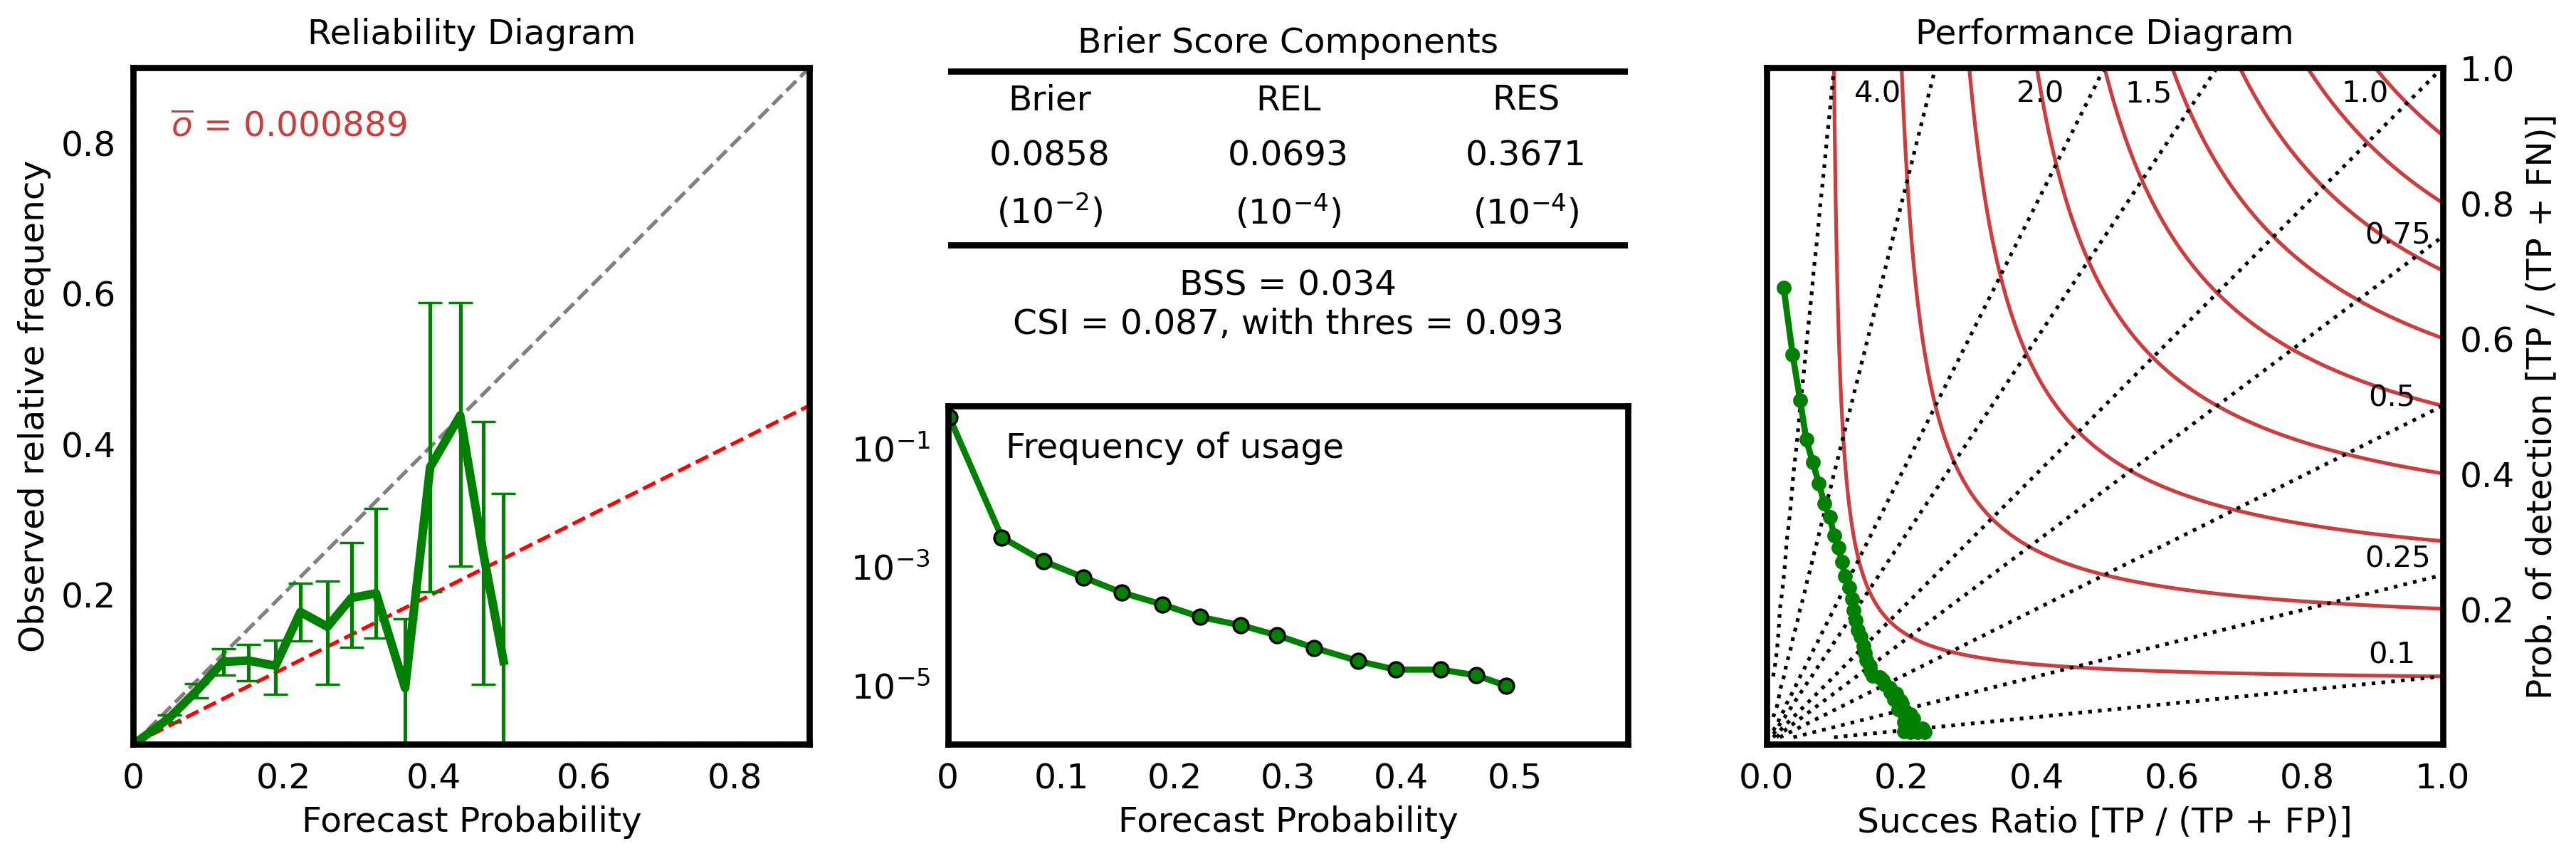

In [30]:
color_ = 'g'

fig = plt.figure(figsize=(13, 3.8), dpi=dpi_)
gs = gridspec.GridSpec(2, 3, height_ratios=[0.5, 0.5], width_ratios=[1/3, 1/3, 1/3])

ax_re = plt.subplot(gs[:, 0])
ax_csi = plt.subplot(gs[:, 2])
ax_table = plt.subplot(gs[0, 1])
ax_freq = plt.subplot(gs[1, 1])

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.2)

# ========== #
ax = ax_re
# ========== #
ax = gu.ax_decorate_box(ax)
# no skill line
fake_x = np.linspace(0, 1, 100)
fake_y = 0.5*fake_x + 0.5*o_bar_t
ax.plot(fake_x, fake_x, linewidth=1.5, linestyle='--', color='0.5')
ax.plot(fake_x, fake_y, linewidth=1.5, linestyle='--', color='r')
# axis ticks
ax.tick_params(axis="both", which="both", labelbottom=True, labelleft=True)
ax.set_xlim([0, 0.9])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8])
ax.set_ylim([0, 0.9])
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels([0.2, 0.4, 0.6, 0.8])
ax.set_aspect('equal')
# axis labels
ax.set_ylabel('Observed relative frequency', fontsize=14)
ax.set_xlabel('Forecast Probability', fontsize=14)
# climatology line
ax.text(0.05, 0.8, r'$\overline{o}$ = 0.000889', ha='left', va='bottom', color=red, fontsize=14)
ax.axvline(x=o_bar_t, ymin=0, ymax=1, linewidth=1.5, linestyle='--', color='0.5')
ax.axhline(y=o_bar_t, xmin=0, xmax=1, linewidth=1.5, linestyle='--', color='0.5')
ax.text(0.5, 1.025, 'Reliability Diagram', ha='center', va='bottom', color='k', fontsize=14, transform=ax.transAxes)

temp_95_t = np.quantile(prob_true_t, 0.95, axis=1) - prob_true_mean_t
temp_05_t = prob_true_mean_t - np.quantile(prob_true_t, 0.05, axis=1)
error_t = np.array(list(zip(temp_05_t, temp_95_t))).T
ax.errorbar(prob_pred_mean_t, prob_true_mean_t, yerr=error_t, linestyle='-', capsize=5, color=color_, linewidth=3.5, elinewidth=1.5)

# ========== #
ax = ax_table
# ========== #
ax.set_axis_off()
table_heads = ['Brier', 'REL', 'RES']
locx_heads = [0.15, 0.50, 0.85]
scales = [r'($10^{-2}$)', r'($10^{-4}$)', r'($10^{-4}$)']
ax.text(0.5, 1.025, 'Brier Score Components', ha='center', va='bottom', color='k', fontsize=14, transform=ax.transAxes)
pad = 0.075

for j in range(3):
    ax.text(locx_heads[j], 0.93-pad, table_heads[j], ha='center', va='bottom', 
                  fontsize=14, transform=ax.transAxes)
    ax.text(locx_heads[j], 0.65-pad, scales[j], ha='center', va='center', 
              fontsize=14, transform=ax.transAxes)
ax.text(locx_heads[0], 0.765-pad, '{:.4f}'.format(bs_t*1e2), ha='center', va='bottom', 
              color='k', fontsize=14, transform=ax.transAxes)
ax.text(locx_heads[1], 0.765-pad, '{:.4f}'.format(rel_t*1e4), ha='center', va='bottom', 
              color='k', fontsize=14, transform=ax.transAxes)
ax.text(locx_heads[2], 0.765-pad, '{:.4f}'.format(res_t*1e4), ha='center', va='bottom', 
              color='k', fontsize=14, transform=ax.transAxes)
ax.axhline(y=0.99, xmin=0, xmax=1.25, linewidth=2.5, linestyle='-', color='k')
ax.axhline(y=0.55-pad, xmin=0, xmax=1.25, linewidth=2.5, linestyle='-', color='k')
ax.text(0.5, 0.375-pad, 'BSS = {:.3f}\nCSI = {:.3f}, with thres = {:.3f}'.format(bss_t, max_t, thres_max_t), ha='center', va='center', 
              fontsize=14, transform=ax.transAxes)

# ========== #
ax = ax_freq
# ========== #
ax = gu.ax_decorate_box(ax)
ax.tick_params(axis="both", which="both", labelbottom=True, labelleft=True)
ax.set_xlim([0, 0.6])
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yscale('log')
ax.set_ylim([1e-6, 0.5])
ax.set_yticks([1e-5, 1e-3, 1e-1])
ax.text(0.2, 0.1, 'Frequency of usage', ha='center', va='center', fontsize=14)
ax.set_xlabel('Forecast Probability', fontsize=14)

ax.plot(hist_bins_t, use_t/Lv, '-o', color=color_, linewidth=2.5, ms=6, mec='k', mfc=color_)

# ========== #
ax = ax_csi
# ========== #
ax = gu.ax_decorate_box(ax)
ax.tick_params(axis="both", which="both", labelbottom=True, labelright=True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_aspect('equal')
x_axis = np.arange(0.01, 1.01, 0.01)
y_axis = np.arange(0.01, 1.01, 0.01)
x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)
csi = ((1 / x_mesh) + (1 / y_mesh) - 1) ** -1
cs_ = ax.contour(x_mesh, y_mesh, csi, np.arange(0.0, 1.1, 0.1), colors=(red,), linestyles='-')
biases = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0, 10.0]
bias_loc_x = [0.94, 0.935, 0.94, 0.935, 0.9, 0.58, 0.42, 0.18, 0.03]
bias_loc_y = [0.12, 0.2625, 0.5, 0.74, 0.95, 0.95, 0.95, 0.95, 0.95]
bias = y_mesh / x_mesh
ax.contour(x_mesh, y_mesh, bias, biases, colors='k', linestyles=':')
for i, label in enumerate(biases):
    ax.annotate(label, (bias_loc_x[i]-0.05, bias_loc_y[i]), fontsize=12)

ax.text(0.5, 1.025, 'Performance Diagram', ha='center', va='bottom', color='k', fontsize=14, transform=ax.transAxes)
ax.set_xlabel('Succes Ratio [TP / (TP + FP)]', fontsize=14)
ax.yaxis.set_label_position("right")

ax.set_ylabel('Prob. of detection [TP / (TP + FN)]', fontsize=14)

ax.plot(sr_t, pod_t, 'o-', color=color_, linewidth=2.5, ms=6, mew=0.0, mfc=color_)

fig.savefig(fig_dir+'relia_bss_perf_v4.png', format='png', **fig_keys)

In [31]:
# auc_score_v, bss_v, bs_v = verf_auc_bss(true_valid, pred_valid[:, 0])
# auc_score_v2, bss_v2, bs_v2 = verf_auc_bss(data_lead2['label_valid'], data_lead2['valid'][:, 0])
# auc_score_v3, bss_v3, bs_v3 = verf_auc_bss(data_lead3['label_valid'], data_lead3['valid'][:, 0])
# auc_score_v4, bss_v4, bs_v4 = verf_auc_bss(data_lead4['label_valid'], data_lead4['valid'][:, 0])

In [32]:
# auc_score_t, bss_t, bs_t = verf_auc_bss(true_test, pred_test[:, 0])
# auc_score_t2, bss_t2, bs_t2 = verf_auc_bss(data_lead2['label_test'], data_lead2['test'][:, 0])
# auc_score_t3, bss_t3, bs_t3 = verf_auc_bss(data_lead3['label_test'], data_lead3['test'][:, 0])
# auc_score_t4, bss_t4, bs_t4 = verf_auc_bss(data_lead4['label_test'], data_lead4['test'][:, 0])

### Full domain examples

In [33]:
base_v3_s = datetime(2018, 7, 15)
base_v3_e = datetime(2020, 12, 2)

base_v4_s = datetime(2020, 12, 3)
base_v4_e = datetime(2022, 7, 15)

base_ref = datetime(2010, 1, 1)

date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180)]

In [34]:
def id_extract(filenames):
    
    indx_out = []
    indy_out = []
    days_out = []
    
    for i, name in enumerate(filenames):
        nums = re.findall(r'\d+', name)
        lead = int(nums[-1])
        indy = int(nums[-2])
        indx = int(nums[-3])
        day = int(nums[-4])
                
        indx_out.append(indx)
        indy_out.append(indy)
        days_out.append(day)
        
    return np.array(indx_out), np.array(indy_out), np.array(days_out)


In [35]:
indx_valid, indy_valid, days_valid = id_extract(filename_valid)

In [36]:
indx_test, indy_test, days_test = id_extract(filename_test)

In [37]:
def aspc_cal(edge):
    return (edge[3]-edge[2])/(edge[1]-edge[0])

def gcd(a, b):
    if b == 0:
        return a
    else:
        return gcd(b, a % b)

# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [38]:
day_start = 601
day_end = 871
shape_72km = lon_80km.shape

prob_grid_v = np.empty((day_end-day_start+1,)+shape_72km)
true_grid_v = np.empty((day_end-day_start+1,)+shape_72km)

prob_grid_v[...] = np.nan
true_grid_v[...] = np.nan

for i in range(278587):
    day = days_valid[i]
    indx = indx_valid[i]
    indy = indy_valid[i]
    
    prob_grid_v[day-day_start, indx, indy] = pred_valid[i, 0]
    true_grid_v[day-day_start, indx, indy] = true_valid[i]

/glade/scratch/ksha/ipykernel_283153/1080235655.py:64: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(fig_dir+'example_output_lead2.png', format='png', **fig_keys)


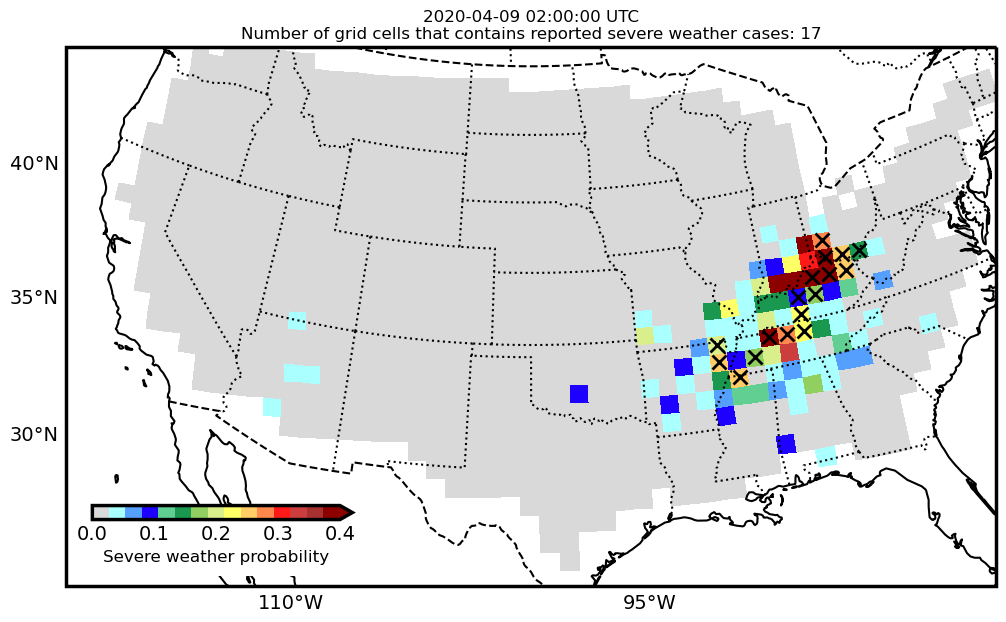

In [39]:
edge = [-120, -80, 27.5, 47.5]
cmap_pct, A = gu.precip_cmap()
proj_ = ccrs.NorthPolarStereo(central_longitude=-100)

lead = 2

for day in range(day_start, day_end, 1):

    # dt_temp = date_list_v3[day]
    # dt_year = dt_temp.year
    # dt_nday = (dt_temp - datetime(dt_year, 1, 1)).days

    record_temp = true_grid_v[day-day_start, ...]
    
    lon_temp = lon_80km[record_temp>0]
    lat_temp = lat_80km[record_temp>0]
    
    N_case = len(lon_temp)
    
    if N_case > 15:
        
        fig = plt.figure(figsize=(13, 7))
        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = plt.axes(projection=proj_)
        
        ax.set_extent(edge, ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=6)
        ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=6)
        ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=5)

        GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', linewidth=0, zorder=5)
        GL.top_labels = None
        GL.right_labels = None
        GL.xlocator = mticker.FixedLocator([-125, -110, -95, -80])
        GL.ylocator = mticker.FixedLocator([30, 35, 40, 45])
        GL.xlabel_style = {'size': 14}
        GL.ylabel_style = {'size': 14}
        GL.rotate_labels = False
        # # grid lines but lines only
        # GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, x_inline=False, y_inline=False, color='k', linestyle=':', zorder=5)
        
        ax.spines['geo'].set_linewidth(2.5)

        CS = ax.pcolormesh(lon_80km, lat_80km, prob_grid_v[day-day_start, ...], vmin=0, vmax=0.4, cmap=cmap_pct, transform=ccrs.PlateCarree())
        ax.plot(lon_temp, lat_temp, 'kx', ms=10, mec='k', mew=2.0, mfc='k', transform=ccrs.PlateCarree())
        ax.set_title('{} UTC\nNumber of grid cells that contains reported severe weather cases: {}'.format(date_list_v3[day]+timedelta(hours=lead), N_case))
        ax.set_xlabel('lon', fontsize=14)
        ax.set_ylabel('lat', fontsize=14)
        
        # #pad = 0.05
        # points = np.array([[-127, 26], [-110, 26], [-110, 30], [-127, 30],])
        # mask = PatchCollection([patches.Polygon(points)], facecolor='r', linewidth=0, transform=ccrs.PlateCarree(), zorder=6)
        # ax.add_collection(mask)
        
        ax_base = fig.add_axes([0.175, 0.125, 0.2, 0.1])
        [j.set_linewidth(0.0) for j in ax_base.spines.values()]
        ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
        cax = inset_axes(ax_base, height='20%', width='100%', borderpad=0, loc=2)
        CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0, 0.1, 0.2, 0.3, 0.4], extend='max', cax=cax)
        CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
        CBar.set_label('Severe weather probability', fontsize=12)
        CBar.outline.set_linewidth(2.5)
        fig.savefig(fig_dir+'example_output_lead2.png', format='png', **fig_keys)
        break;

In [40]:
day_start = 601
day_end = 871
shape_72km = lon_80km.shape

prob_grid_v = np.empty((day_end-day_start+1,)+shape_72km)
true_grid_v = np.empty((day_end-day_start+1,)+shape_72km)

prob_grid_v[...] = np.nan
true_grid_v[...] = np.nan

for i in range(557176, Lv, 1):
    day = days_valid[i]
    indx = indx_valid[i]
    indy = indy_valid[i]
    
    prob_grid_v[day-day_start, indx, indy] = pred_valid[i, 0]
    true_grid_v[day-day_start, indx, indy] = true_valid[i]

/glade/scratch/ksha/ipykernel_283153/326170951.py:64: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(fig_dir+'example_output_lead4.png', format='png', **fig_keys)


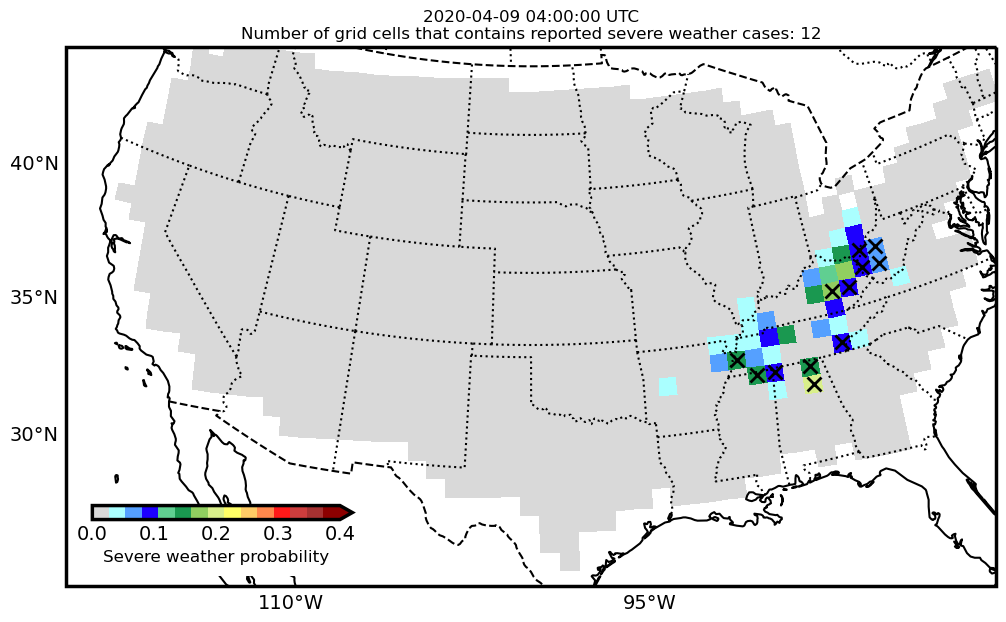

In [41]:
edge = [-120, -80, 27.5, 47.5]
cmap_pct, A = gu.precip_cmap()
proj_ = ccrs.NorthPolarStereo(central_longitude=-100)

lead = 4

for day in range(day_start, day_end, 1):

    # dt_temp = date_list_v3[day]
    # dt_year = dt_temp.year
    # dt_nday = (dt_temp - datetime(dt_year, 1, 1)).days

    record_temp = true_grid_v[day-day_start, ...]
    
    lon_temp = lon_80km[record_temp>0]
    lat_temp = lat_80km[record_temp>0]
    
    N_case = len(lon_temp)
    
    if N_case > 11:
        
        fig = plt.figure(figsize=(13, 7))
        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = plt.axes(projection=proj_)
        
        ax.set_extent(edge, ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=6)
        ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=6)
        ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=5)

        GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', linewidth=0, zorder=5)
        GL.top_labels = None
        GL.right_labels = None
        GL.xlocator = mticker.FixedLocator([-125, -110, -95, -80])
        GL.ylocator = mticker.FixedLocator([30, 35, 40, 45])
        GL.xlabel_style = {'size': 14}
        GL.ylabel_style = {'size': 14}
        GL.rotate_labels = False
        # # grid lines but lines only
        # GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, x_inline=False, y_inline=False, color='k', linestyle=':', zorder=5)
        
        ax.spines['geo'].set_linewidth(2.5)

        CS = ax.pcolormesh(lon_80km, lat_80km, prob_grid_v[day-day_start, ...], vmin=0, vmax=0.4, cmap=cmap_pct, transform=ccrs.PlateCarree())
        ax.plot(lon_temp, lat_temp, 'kx', ms=10, mec='k', mew=2.0, mfc='k', transform=ccrs.PlateCarree())
        ax.set_title('{} UTC\nNumber of grid cells that contains reported severe weather cases: {}'.format(date_list_v3[day]+timedelta(hours=lead), N_case))
        ax.set_xlabel('lon', fontsize=14)
        ax.set_ylabel('lat', fontsize=14)
        
        # #pad = 0.05
        # points = np.array([[-127, 26], [-110, 26], [-110, 30], [-127, 30],])
        # mask = PatchCollection([patches.Polygon(points)], facecolor='r', linewidth=0, transform=ccrs.PlateCarree(), zorder=6)
        # ax.add_collection(mask)
        
        ax_base = fig.add_axes([0.175, 0.125, 0.2, 0.1])
        [j.set_linewidth(0.0) for j in ax_base.spines.values()]
        ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
        cax = inset_axes(ax_base, height='20%', width='100%', borderpad=0, loc=2)
        CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0, 0.1, 0.2, 0.3, 0.4], extend='max', cax=cax)
        CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
        CBar.set_label('Severe weather probability', fontsize=12)
        CBar.outline.set_linewidth(2.5)
        fig.savefig(fig_dir+'example_output_lead4.png', format='png', **fig_keys)
        break;

In [42]:
day_start = 0
day_end = 393
shape_72km = lon_80km.shape

prob_grid_t = np.empty((day_end-day_start+1,)+shape_72km)
true_grid_t = np.empty((day_end-day_start+1,)+shape_72km)

prob_grid_t[...] = np.nan
true_grid_t[...] = np.nan

for i in range(405032):
    day = days_test[i]
    indx = indx_test[i]
    indy = indy_test[i]
    
    prob_grid_t[day-day_start, indx, indy] = pred_test[i, 0]
    true_grid_t[day-day_start, indx, indy] = true_test[i]

/glade/scratch/ksha/ipykernel_283153/1241254399.py:64: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(fig_dir+'example_output_lead2_v4.png', format='png', **fig_keys)


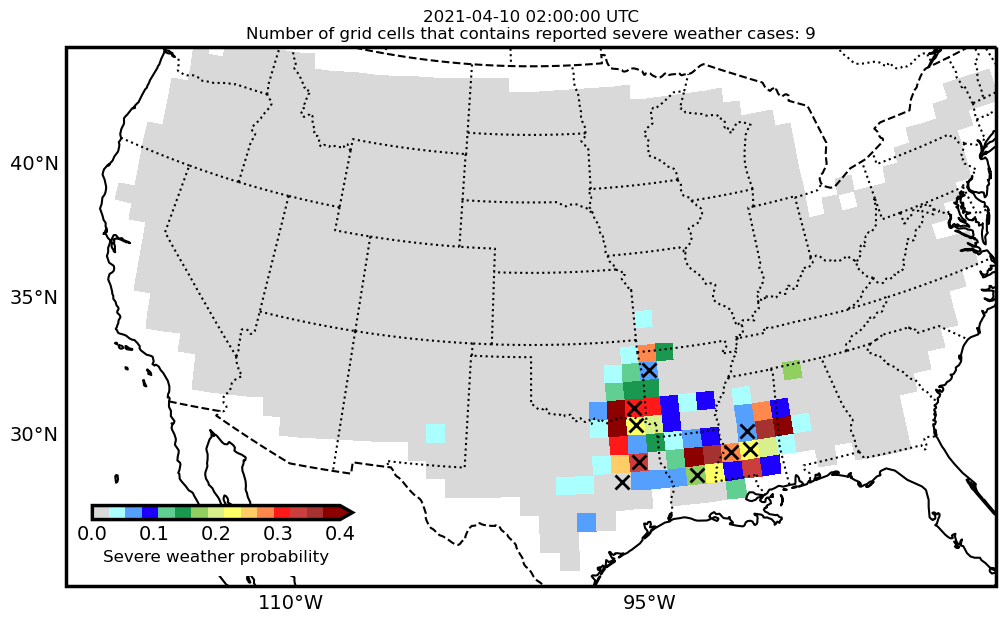

In [43]:
edge = [-120, -80, 27.5, 47.5]
cmap_pct, A = gu.precip_cmap()
proj_ = ccrs.NorthPolarStereo(central_longitude=-100)

lead = 2

for day in range(day_start, day_end, 1):

    # dt_temp = date_list_v3[day]
    # dt_year = dt_temp.year
    # dt_nday = (dt_temp - datetime(dt_year, 1, 1)).days

    record_temp = true_grid_t[day-day_start, ...]
    
    lon_temp = lon_80km[record_temp>0]
    lat_temp = lat_80km[record_temp>0]
    
    N_case = len(lon_temp)
    
    if N_case > 7:
        
        fig = plt.figure(figsize=(13, 7))
        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = plt.axes(projection=proj_)
        
        ax.set_extent(edge, ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=6)
        ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=6)
        ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=5)

        GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', linewidth=0, zorder=5)
        GL.top_labels = None
        GL.right_labels = None
        GL.xlocator = mticker.FixedLocator([-125, -110, -95, -80])
        GL.ylocator = mticker.FixedLocator([30, 35, 40, 45])
        GL.xlabel_style = {'size': 14}
        GL.ylabel_style = {'size': 14}
        GL.rotate_labels = False
        # # grid lines but lines only
        # GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, x_inline=False, y_inline=False, color='k', linestyle=':', zorder=5)
        
        ax.spines['geo'].set_linewidth(2.5)

        CS = ax.pcolormesh(lon_80km, lat_80km, prob_grid_t[day-day_start, ...], vmin=0, vmax=0.4, cmap=cmap_pct, transform=ccrs.PlateCarree())
        ax.plot(lon_temp, lat_temp, 'kx', ms=10, mec='k', mew=2.0, mfc='k', transform=ccrs.PlateCarree())
        ax.set_title('{} UTC\nNumber of grid cells that contains reported severe weather cases: {}'.format(date_list_v4[day]+timedelta(hours=lead), N_case))
        ax.set_xlabel('lon', fontsize=14)
        ax.set_ylabel('lat', fontsize=14)
        
        # #pad = 0.05
        # points = np.array([[-127, 26], [-110, 26], [-110, 30], [-127, 30],])
        # mask = PatchCollection([patches.Polygon(points)], facecolor='r', linewidth=0, transform=ccrs.PlateCarree(), zorder=6)
        # ax.add_collection(mask)
        
        ax_base = fig.add_axes([0.175, 0.125, 0.2, 0.1])
        [j.set_linewidth(0.0) for j in ax_base.spines.values()]
        ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
        cax = inset_axes(ax_base, height='20%', width='100%', borderpad=0, loc=2)
        CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0, 0.1, 0.2, 0.3, 0.4], extend='max', cax=cax)
        CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
        CBar.set_label('Severe weather probability', fontsize=12)
        CBar.outline.set_linewidth(2.5)
        fig.savefig(fig_dir+'example_output_lead2_v4.png', format='png', **fig_keys)
        break;